### Backtesting
- 구현한 모델을 통한 수익률 예측
- 구현 날짜: 2024.03.11
- 딥러닝 적용
- 챗지피티 full code 작성
- 고려사항: num_rows 값에 의해 없어진 sequence 같은거 계산 어떻게 해야하지..?

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다. {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다. {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 맥(OS X) 운영 체제입니다. mps is available


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # 데이터 불러오기
# file_path = '../../data/' # 경로 설정
# df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
# df = df.iloc[:10000]
# df['returns_next10m_binary'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
# #df = df.reset_index()
# df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
# df

,window_start,window_end,num_rows,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,ending_price,...,ob_end_bias_0,ob_end_bias_1,ob_end_bias_4,ob_end_bidask_spread,ob_end_liq_0,ob_end_liq_1,ob_end_liq_4,highest_possible_return,del_idx,returns_next10m_binary
0,2022-12-16 21:05:30,2022-12-16 21:06:00,14,0.000000,0.000089,0.000089,1.468656,0.747351,22568000.0,22570000.0,...,5.470422,10.649683,3.235541,2.0,0.001693,0.002198,0.002412,1.000000,0,0
1,2022-12-16 21:06:00,2022-12-16 21:06:30,10,0.000000,0.000089,0.000089,0.567585,0.027857,22568000.0,22570000.0,...,4.224361,14.918538,3.856600,2.0,0.000531,0.001064,0.001471,1.000000,0,0
2,2022-12-16 21:06:30,2022-12-16 21:07:00,24,-0.000576,0.000044,0.000620,1.677093,0.146635,22570000.0,22570000.0,...,17.677511,9.697905,1.106227,14.0,0.000449,0.000536,0.001821,0.999778,0,0
3,2022-12-16 21:07:00,2022-12-16 21:07:30,22,-0.000044,0.000443,0.000488,2.439677,0.751995,22557000.0,22567000.0,...,95.630870,3.371113,1.367349,2.0,0.000416,0.000480,0.001422,0.999911,0,0
4,2022-12-16 21:07:30,2022-12-16 21:08:00,24,-0.000443,0.000000,0.000443,2.345821,-0.915608,22565000.0,22555000.0,...,0.114815,0.828364,0.068175,10.0,0.000311,0.000560,0.003454,0.999911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022-12-21 17:21:00,2022-12-21 17:21:30,19,-0.000046,0.000000,0.000046,0.425454,-0.948161,21934000.0,21933000.0,...,0.350348,0.722525,2.240041,1.0,0.001326,0.001373,0.001813,1.000456,0,1
9996,2022-12-21 17:21:30,2022-12-21 17:22:00,11,0.000000,0.000046,0.000046,0.415851,-0.702673,21933000.0,21934000.0,...,1.262898,2.066462,2.201207,1.0,0.000978,0.001022,0.001402,1.000456,0,1
9997,2022-12-21 17:22:00,2022-12-21 17:22:30,9,-0.000046,0.000000,0.000046,0.195132,-0.289384,21934000.0,21933000.0,...,1.508781,2.745012,2.505091,1.0,0.000677,0.000721,0.001089,1.000501,0,1
9998,2022-12-21 17:22:30,2022-12-21 17:23:00,30,-0.000137,0.000000,0.000137,0.460736,-0.406754,21933000.0,21930000.0,...,2.547770,2.898483,1.954013,3.0,0.000361,0.000500,0.000914,1.000501,0,1


In [13]:
def create_sequence(df, seq_len):
    # 1. 변수 선택
    # 종속변수 리스트
    target_var_lst = ['returns', 'returns_next10m', 'realized_vol_next10m']
    target_var = 'returns_next10m' # 종속변수

    # 시퀀스 생성 전 필요없는 컬럼 삭제
    df.drop(columns=['window_start', 'window_end','num_rows', 'time_id'], inplace=True) # 시간 관련 변수

    # target을 제외한 나머지 종속변수 삭제
    cols_to_drop = [var for var in target_var_lst if var != target_var]
    df.drop(columns=cols_to_drop, inplace=True) # 종속변수
    #df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) 2진 분류화는 ipynb 파일에서 직접 수행

    # 종속변수를 데이터 프레임 맨 뒤로 옮기기
    cols = df.columns.tolist()
    cols = [col for col in cols if col != 'returns_next10m'] + ['returns_next10m'] # 종속변수 맨 뒤로
    df = df[cols]

    # 2. sequence 생성
    sequences = []
    scaler = MinMaxScaler()
    
    for start_idx in range(len(df) - seq_len + 1):  # 데이터 프레임을 순회하며 시퀀스 생성
        end_idx = start_idx + seq_len
        sequence = df.iloc[start_idx:end_idx]
        
        # 시퀀스 내에 del_idx가 1인 행이 있다면, 해당 시퀀스를 제외
        if sequence['del_idx'].sum() == 0:
            # 예측하고자 하는 마지막 피처의 값을 제외하고 스케일링
            scaled_sequence = scaler.fit_transform(sequence.drop(columns=['del_idx', target_var]))
            
            # 스케일링된 시퀀스에 예측하고자 하는 마지막 피처의 값을 추가
            scaled_sequence_with_target = pd.concat([pd.DataFrame(scaled_sequence), sequence[target_var].reset_index(drop=True)], axis=1)
            
            # 최종 시퀀스 추가
            sequences.append(scaled_sequence_with_target.values)
            
    # 3. X, y split
    sequences = np.array(sequences)
    # X와 y를 분리
    X = sequences[:, :, :-1] # 마지s막 시퀀스와 마지막 컬럼을 제외한 나머지
    y = sequences[:, -1, -1].reshape(-1, 1) # 각 시퀀스의 마지막 행, 마지막 컬럼의 값

    return X, y


In [2]:
def create_sequence_with_index(df, seq_len):
    df.drop(columns=['window_start', 'window_end','num_rows', 'time_id'], inplace=True) # 시간 관련 변수

    sequences = []
    scaler = MinMaxScaler()
    sequence_indices = []  # 시퀀스의 마지막 행 인덱스를 저장할 리스트
    target_var = 'returns_next10m' # 종속변수

    
    for start_idx in range(len(df) - seq_len + 1):
        end_idx = start_idx + seq_len
        sequence = df.iloc[start_idx:end_idx]
        
        if sequence['del_idx'].sum() == 0:
            scaled_sequence = scaler.fit_transform(sequence.drop(columns=['del_idx', target_var]))
            scaled_sequence_with_target = pd.concat([pd.DataFrame(scaled_sequence), sequence[target_var].reset_index(drop=True)], axis=1)
            sequences.append(scaled_sequence_with_target.values)
            sequence_indices.append(sequence.index[-1])  # 마지막 행의 인덱스 추가
    
    sequences = np.array(sequences)
    X = sequences[:, :, :-1]
    y = sequences[:, -1, -1].reshape(-1, 1)
    indices = np.array(sequence_indices)  # 마지막 행 인덱스를 numpy 배열로 변환
    
    return X, y, indices


In [26]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:10000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
#df = df.reset_index() # backtesting을 위한 index 값 생성

# # sequence length를 기준으로 sequence 데이터 생성
# seq_len = 20 # 20, 40, 80, 160, 320
# X, y = create_sequence(df, seq_len=seq_len) # 사용자 정의 함수
# # Tensor화
# X_torch = torch.FloatTensor(X).to(device)
# y_torch = torch.FloatTensor(y).to(device)
# print('Full Data Size:', X_torch.size(), y_torch.size())

# # split (80% / 20%)
# train_split = int((X_torch.size(0)) * 0.8)

# X_train_seq = X_torch[:train_split]
# X_test_seq = X_torch[train_split:]
# y_train_seq = y_torch[:train_split]
# y_test_seq = y_torch[train_split:]

# print('Train Size:', X_train_seq.size(), y_train_seq.size())
# print('Test Size:', X_test_seq.size(), y_test_seq.size())


In [9]:
# # Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
# train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
# test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
# batch_size = 64 # 32, 64, 128
# train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
# test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # input_seq의 형태가 (batch, seq_len, input_size)임을 가정
        lstm_out, _ = self.lstm(input_seq)
        # lstm_out의 형태: (batch, seq_len, hidden_layer_size), 여기서 마지막 타임스텝의 출력만 사용
        predictions = self.linear(lstm_out[:, -1, :])  # 마지막 시간 단계의 출력만 선형 계층에 전달
        return predictions


In [30]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:10000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# 모델 초기화 및 학습 설정
model = LSTMModel(input_size=77, hidden_layer_size=100, output_size=1)  # input_size 조정 필요
loss_function = nn.BCEWithLogitsLoss()  # 이진 분류
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 데이터 준비
X, y = create_sequence(df, seq_len=50)  # 예시에서는 seq_len을 50으로 설정

# 데이터를 텐서로 변환
X_train_tensors = torch.Tensor(X)
y_train_tensors = torch.Tensor(y)

# 데이터 로더 준비
train_data = TensorDataset(X_train_tensors, y_train_tensors)
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)

seq_len = 50

# 학습 과정
epochs = 10
for i in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()

        y_pred = model(seq)    
        labels = labels.view(-1, 1)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')


epoch:   1 loss: 0.36625698
epoch:   3 loss: 0.29901072
epoch:   5 loss: 0.10612320
epoch:   7 loss: 0.12952331
epoch:   9 loss: 0.09361447


In [33]:
# 예시 코드 - 실제 데이터와 모델을 기반으로 작성해야 함
capital = 100000  # 초기 자본
fee_rate = 0.00005  # 수수료율
scaler = MinMaxScaler()

for idx in range(len(df) - seq_len):
    current_sequence = df.iloc[idx:idx+seq_len]
    current_sequence_scaled = scaler.fit_transform(current_sequence.drop(columns=['del_idx', 'returns_next10m']))
    
    current_sequence_tensor = torch.Tensor(current_sequence_scaled).unsqueeze(0)  # 모델 입력 형태에 맞춤
    prediction = model(current_sequence_tensor)
    
    # 여기서 prediction을 기반으로 거래 결정을 내리고, 자본과 수익률 계산을 수행합니다.
    # 예측 결과에 따른 거래 로직 및 수익 계산은 프로젝트의 목적과 설정에 따라 달라질 수 있습니다.


In [36]:
import torch

# MinMaxScaler 인스턴스 생성 (필요한 경우)
scaler = MinMaxScaler()
# scaler.fit(데이터셋) # 스케일러를 전체 데이터셋에 맞게 미리 학습시켜야 합니다.

capital = 100000  # 초기 자본
fee_rate = 0.00005  # 수수료율
total_fee = 0  # 총 수수료
profit = 0  # 수익

# sigmoid 함수를 정의하여 logits을 확률로 변환
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

for idx in range(len(df) - seq_len):
    current_sequence = df.iloc[idx:idx+seq_len]
    # 모델 입력을 위한 현재 시퀀스 스케일링
    current_sequence_scaled = scaler.fit_transform(current_sequence.drop(columns=['del_idx', 'returns_next10m']))
    current_sequence_tensor = torch.Tensor(current_sequence_scaled).unsqueeze(0)  # 모델 입력 형태에 맞춤
    
    # 모델 예측
    prediction = model(current_sequence_tensor)
    # 예측 결과를 확률로 변환 (BCEWithLogitsLoss를 사용했기 때문에)
    prediction = sigmoid(prediction)
    
    # 매수 또는 매도 결정
    if prediction >= 0.5:  # 매수 결정
        # 실제 수익률 계산을 위해 다음 10분의 수익률을 사용
        actual_return = df.iloc[idx+seq_len]['returns_next10m']
        # 매수 후 매도 시 예상 수익
        trade_profit = capital * actual_return - (capital * fee_rate)
        profit += trade_profit
        total_fee += capital * fee_rate
    else: None

# 최종 결과 출력
final_capital = capital + profit
print(f"최초 자본: {capital}")
print(f"최종 자본: {final_capital}")
print(f"총 수익: {profit}")
print(f"총 수수료: {total_fee}")


최초 자본: 100000
최종 자본: 232480445.0
총 수익: 232380445.0
총 수수료: 19555.0


Data Imbalance: Counter({0.0: 520, 1.0: 362})
Accuracy: 0.4104
Precision: 0.4104
Recall: 1.0
F1 Score: 0.582


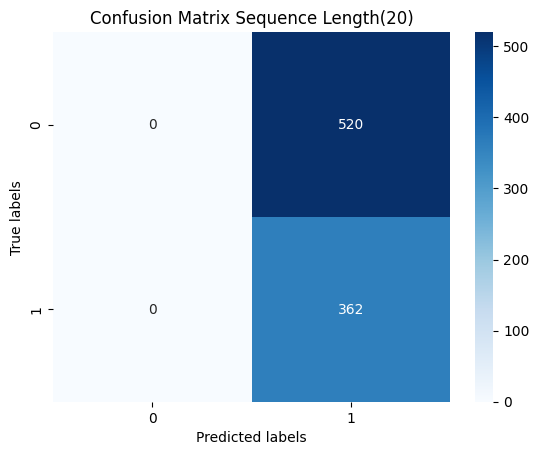

In [37]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()